Ticker dopo filtro market cap: ['MVST', 'VCEL', 'MTX', 'AMPX', 'SHLS', 'GO', 'BLFS', 'CTOS', 'JBI', 'AMPL', 'WVE', 'JANX', 'NGVT', 'UFPT', 'MLKN', 'CLDT', 'WERN', 'PEB', 'NUS']


[*********************100%***********************]  19 of 19 completed



Prime righe del dataset dicembre→gennaio:
  ticker  year  dec_return  jan_return
4   MVST  2019    0.006061    0.000000
5   MVST  2020    0.324555   -0.084211
6   MVST  2021   -0.333333   -0.021201
7   MVST  2022   -0.301370    0.065359
8   MVST  2023    0.196581   -0.330000

=== RISULTATI REGRESSIONE ===
                            OLS Regression Results                            
Dep. Variable:             jan_return   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.554
Date:                Wed, 05 Nov 2025   Prob (F-statistic):              0.112
Time:                        13:18:20   Log-Likelihood:                 67.211
No. Observations:                 130   AIC:                            -130.4
Df Residuals:                     128   BIC:                            -124.7
Df Model:                           1                       

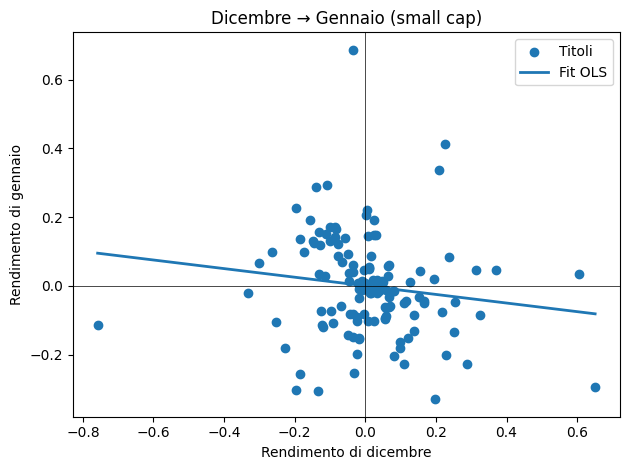

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# =========================
# 1) LISTA DI PARTENZA (50 circa)
# =========================
candidate_tickers = [
    "MVST",
    "VCEL",
    "MTX",
    "AMPX",
    "SHLS",
    "GO",
    "BLFS",
    "CTOS",
    "JBI",
    "AMPL",
    "AGYS",
    "KNTK",
    "ACLX",
    "PRVA",
    "IDYA",
    "WVE",
    "JANX",
    "BRZE",
    "RNA",
    "BBIO",
    "EPRT",
    "DY",
    "PECO",
    "SLG",
    "MC",
    "NGVT",
    "UFPT",
    "MLKN",
    "CWK",
    "DAN",
    "HBI",
    "AGTI",
    "CLDT",
    "SPWR",
    "ATNI",
    "WERN",
    "BFH",
    "PEB",
    "RGP",
    "CARG",
    "DOUG",
    "INGN",
    "NUVA",
    "SJW",
    "NUS",
]

# =========================
# 2) FILTRA PER MARKET CAP
#    (small cap circa: 3e8 - 2e9 USD)
# =========================
filtered = []
for t in candidate_tickers:
    info = yf.Ticker(t).info
    mcap = info.get("marketCap", None)
    if mcap is None:
        continue
    if 3e8 <= mcap <= 2e9:  # range small cap (puoi cambiare)
        filtered.append(t)

print("Ticker dopo filtro market cap:", filtered)
# se sono troppo pochi, puoi allargare il range sopra

# se vuoi forzare a max 50:
tickers = filtered[:50]

# =========================
# 3) SCARICO DATI MENSILI
# =========================
start_date = "2015-01-01"
end_date = "2024-12-31"

data = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    interval="1mo",
    auto_adjust=True,
    group_by="ticker",
    threads=True,
)

# =========================
# 4) COSTRUISCO I RENDIMENTI MENSILI
# =========================
returns = {}
for t in tickers:
    # alcuni ticker potrebbero non avere dati completi
    try:
        close = data[t]["Close"].dropna()
    except Exception:
        continue
    ret = close.pct_change().dropna()
    returns[t] = ret

returns_df = pd.DataFrame(returns)

# =========================
# 5) COSTRUISCO DATASET DICEMBRE → GENNAIO
#    riga = (ticker, year, dec_return, jan_return)
# =========================
rows = []
for t in returns_df.columns:
    # anni disponibili in cui ho almeno dicembre e gennaio successivo
    years = returns_df.index.year.unique()
    for y in years:
        try:
            dec_ret = returns_df.loc[pd.Timestamp(year=y, month=12, day=1), t]
            jan_ret = returns_df.loc[pd.Timestamp(year=y + 1, month=1, day=1), t]
            rows.append(
                {"ticker": t, "year": y, "dec_return": dec_ret, "jan_return": jan_ret}
            )
        except KeyError:
            # se manca dicembre o gennaio successivo, salto
            continue

df_dec_jan = pd.DataFrame(rows)
df_dec_jan = df_dec_jan.dropna()

print("\nPrime righe del dataset dicembre→gennaio:")
print(df_dec_jan.head())

# se il dataset è troppo piccolo, potete allargare il periodo o rilassare il filtro market cap

# =========================
# 6) REGRESSIONE: jan = alpha + beta * dec
# =========================
X = sm.add_constant(df_dec_jan["dec_return"])
y = df_dec_jan["jan_return"]

model = sm.OLS(y, X).fit()
print("\n=== RISULTATI REGRESSIONE ===")
print(model.summary())

# =========================
# 7) PLOT SCATTER + RETTA
# =========================
plt.scatter(df_dec_jan["dec_return"], df_dec_jan["jan_return"], label="Titoli")
# retta stimata
x_line = np.linspace(
    df_dec_jan["dec_return"].min(), df_dec_jan["dec_return"].max(), 100
)
y_line = model.params["const"] + model.params["dec_return"] * x_line
plt.plot(x_line, y_line, label="Fit OLS", linewidth=2)
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.xlabel("Rendimento di dicembre")
plt.ylabel("Rendimento di gennaio")
plt.title("Dicembre → Gennaio (small cap)")
plt.legend()
plt.tight_layout()
plt.show()